# Ethanol uptake triggers upregulation of tryptophan synthesis 

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7fc310739240>

In [3]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [4]:
new_glucose_uptake = bsub.solution.x_dict['EX_glc__D_e']*0.5
base_mu = bsub.solution.f

Bacillus subtilis cannot grow in ethanol only

In [5]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
bsub.reactions.get_by_id('EX_etoh_e').lower_bound = -1
bsub.reactions.ETOHt3.lower_bound = -999999.0 # This transporter is reversible in E. coli
bsub.optimize()

<Solution 0.00 at 0x7fc30cd49ba8>

But it can use ethanol as carbon source while using glucose as energy

In [6]:
# Adjust glucose uptake
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = new_glucose_uptake
flux_dict = dict()
# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

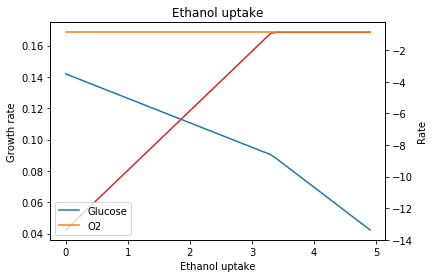

In [7]:
fig,ax1 = plt.subplots()
plt.title('Ethanol uptake')

ax1.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Ethanol uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

Tryptophan production increases, but it could be an artifact of growth rate

Text(0, 0.5, 'Tryptophan production')

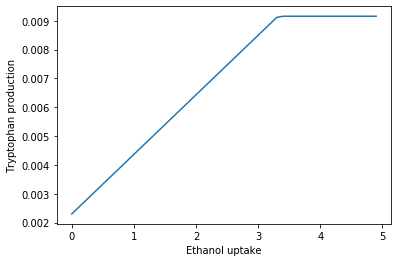

In [8]:
trp_prod = 'TRPS1'
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('Tryptophan production')

Fix growth rate and calculate by minimization of glucose uptake

In [9]:
# Adjust glucose uptake and fix mu to correct the artifact

bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
flux_responses = dict()
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    bsub.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

M-model does not reproduce an increase in Tryptophan production as a result of ethanol processing.

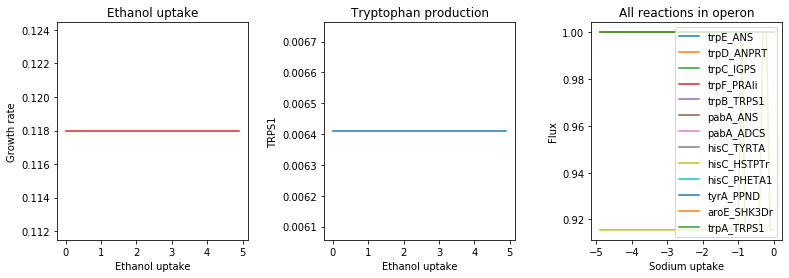

In [10]:
trp_prod = 'TRPS1'

plt.figure(figsize=(13,4))
plt.subplot(1,3,1)

plt.title('Ethanol uptake')
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
plt.xlabel('Ethanol uptake')
plt.ylabel('Growth rate')

plt.subplot(1,3,2)
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('TRPS1')
plt.title('Tryptophan production')

plt.subplot(1,3,3)
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
genes = ['trpE','trpD','trpC','trpF','trpB','pabA','hisC','tyrA','aroE','trpA']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(etoh_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('All reactions in operon')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

plt.subplots_adjust(wspace=0.4)

M-model does not capture changes in tryptophan synthesis

## ME-model simulations of ethanol uptake

In [11]:
# Constrain adjustment
me.reactions.ETOHt3_FWD_CPLX_dummy.lower_bound = -999999.0
me.reactions.get_by_id('EX_glc__D_e').lower_bound = -10

In [12]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [13]:
all_rxns = [rxn.id for rxn in me.reactions]
etoh_rates = -np.arange(0,4,1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [ 0 -1 -2 -3]
Calculating with 4 cores


,-3,-2,-1,0
biomass_dilution,0.356963,0.359382,0.360626,0.361595
protein_biomass_to_biomass,0.120406,0.121187,0.121597,0.121919
mRNA_biomass_to_biomass,0.000608,0.000614,0.000617,0.000619
tRNA_biomass_to_biomass,0.003594,0.003630,0.003646,0.003659
rRNA_biomass_to_biomass,0.026558,0.026819,0.026941,0.027035


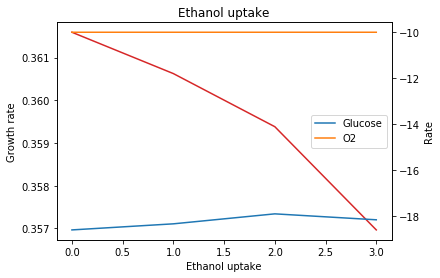

In [14]:
fig,ax1 = plt.subplots()
plt.title('Ethanol uptake')

ax1.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['biomass_dilution'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Ethanol uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

Tryptophan production appears to increase with ethanol uptake.

Text(0, 0.5, 'Tryptophan production')

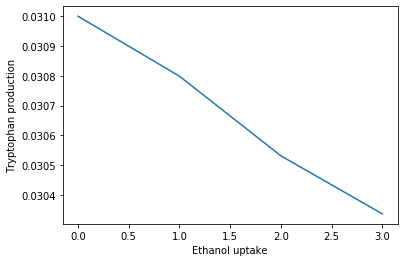

In [15]:
trp_prod = 'TRPS1_FWD_CPLX8J2-19_mod_pydx5p'
plt.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('Tryptophan production')

Is it an artifact of increased growth rate? To test this, growth rate is fixed.

In [16]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [17]:
# Constraint adjustment
base_mu = me.solution.f
new_mu = 0.9*base_mu
me.reactions.ETOHt3_FWD_CPLX_dummy.lower_bound = -999999.0
me.reactions.get_by_id('EX_glc__D_e').lower_bound = new_glucose_uptake

In [18]:
# Calculation at several ethanol uptake rates
all_rxns = [rxn.id for rxn in me.reactions]
etoh_rates = -np.arange(0,5,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,base_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5]
Calculating with 10 cores


,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
biomass_dilution,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956,0.114956
protein_biomass_to_biomass,0.022386,0.022358,0.022194,0.021995,0.021980,0.020941,0.019593,0.019512,0.017407,0.016719
mRNA_biomass_to_biomass,0.000077,0.000076,0.000076,0.000075,0.000075,0.000071,0.000067,0.000067,0.000059,0.000057
tRNA_biomass_to_biomass,0.000457,0.000459,0.000457,0.000452,0.000450,0.000422,0.000399,0.000397,0.000355,0.000341
rRNA_biomass_to_biomass,0.003351,0.003341,0.003317,0.003283,0.003280,0.003120,0.002919,0.002912,0.002599,0.002499


In [19]:
# Save results
flux_responses_me.to_csv('ethanol_flux_responses.csv',index_label='rxn_id')

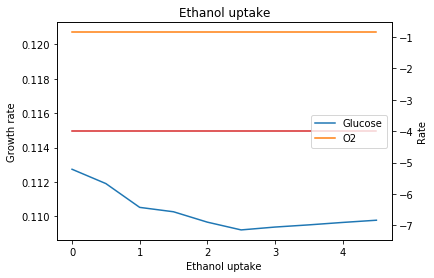

In [20]:
fig,ax1 = plt.subplots()
plt.title('Ethanol uptake')

ax1.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['biomass_dilution'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Ethanol uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses_me.loc['EX_etoh_e'],flux_responses_me.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

In [119]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

Text(0.5, 0, 'Ethanol uptake')

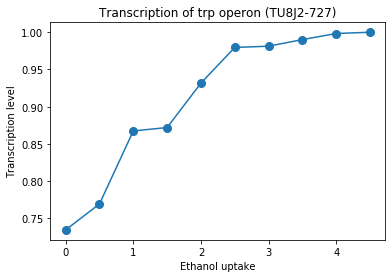

In [120]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Ethanol uptake')

Text(0.5, 1.0, 'promoter')

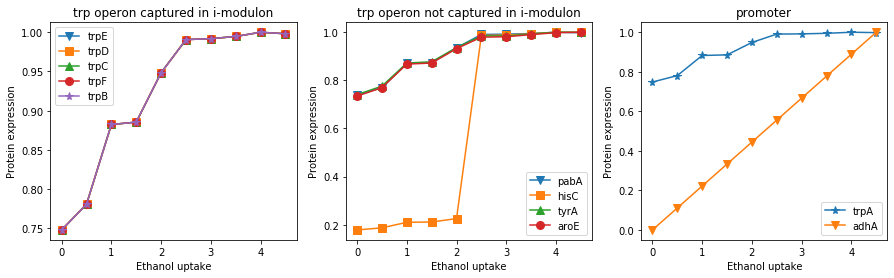

In [121]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.subplot(1,3,1)

genes = ['trpE','trpD','trpC','trpF','trpB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon captured in i-modulon')

plt.subplot(1,3,2)
genes = ['pabA','hisC','tyrA','aroE']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon not captured in i-modulon')

plt.subplot(1,3,3)
genes = ['trpA','adhA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('promoter')


There is a clear trend of upregulation of tryptophan synthesis being captured by the model.

Notes:
* Ethanol diffuses through the membrane (passive transport).


In [108]:
df = flux_responses_me.loc[flux_responses_me.index.str.contains('EX_')]

In [115]:
df2=df[(abs(df).select_dtypes(include=['number']) > 1e-15).any(1)]
df2 = df2.loc[df2.index.str.contains('_e')]
df2

,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
EX_ac_e,3.595040e+00,2.809997e+00,2.023761e+00,1.242547e+00,4.468250e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_co2_e,2.582137e+00,3.152034e+00,3.728579e+00,4.297196e+00,4.887418e+00,5.241154e+00,5.428695e+00,5.617334e+00,5.448952e+00,5.596451e+00
EX_etoh_e,-4.500000e+00,-4.000000e+00,-3.500000e+00,-3.000000e+00,-2.500000e+00,-2.000000e+00,-1.500000e+00,-1.000000e+00,-5.000000e-01,-0.000000e+00
EX_glc__D_e,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01,-8.500000e-01
EX_h2o_e,9.179491e+00,9.250056e+00,9.321361e+00,9.382136e+00,9.474033e+00,9.178480e+00,7.860839e+00,7.818749e+00,5.062737e+00,3.343680e+00
EX_h_e,4.142915e+00,3.357885e+00,2.569012e+00,1.784147e+00,9.888125e-01,2.963328e-01,2.582731e-02,1.544894e-01,5.130869e-01,8.130712e-01
EX_k_e,-1.186410e-07,-1.186410e-07,-1.186503e-07,-1.186410e-07,-1.186503e-07,-1.117077e-07,-3.176957e-08,-6.535597e-08,-9.095018e-08,-1.366392e-07
EX_mg2_e,-3.991520e-04,-3.983916e-04,-3.952483e-04,-3.851522e-04,-3.909922e-04,-3.658874e-04,-3.421150e-04,-3.407799e-04,-3.041294e-04,-2.926868e-04
EX_nh4_e,-7.558241e-01,-7.559602e-01,-7.535076e-01,-7.499583e-01,-7.505202e-01,-6.474850e-01,-2.760658e-01,-5.062610e-01,5.182118e-02,2.958519e-01
EX_o2_e,-6.837781e+00,-6.908433e+00,-6.986004e+00,-7.055466e+00,-7.146477e+00,-6.898831e+00,-6.568349e+00,-6.428451e+00,-5.670406e+00,-5.214662e+00


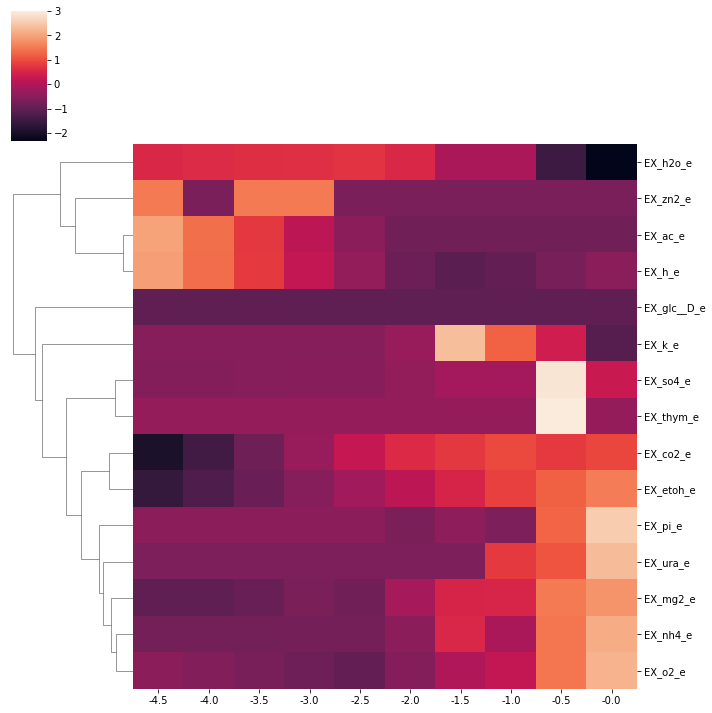

In [116]:
import seaborn as sns
from scipy import stats
a = pd.DataFrame(data=stats.zscore(df2,axis=1),
                 index=df2.index,columns=df2.columns)
sns.clustermap(a,col_cluster = False)

In [94]:
bsub.solution.x_dict['EX_ura_e']

0.0